In [10]:
!pip install pyspark
!pip install imblearn
!pip install tensorflow
!pip install gensim

In [11]:
# Importar modulos
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import builtins
import tensorflow as tf
import requests
import re
from io import BytesIO
from collections import Counter
from scipy.stats import chi2_contingency
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.neural_network import MLPClassifier
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, GRU, LSTM, SimpleRNN, Dense, Dropout, Input, Concatenate, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import SparseTopKCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from gensim.models import Word2Vec

# Crear sesión de Spark
spark = SparkSession.builder.getOrCreate()

In [12]:
# FUNCIONES

# Obtiene primer elemento separado por -
def get_first_part(value):
    if value is not None:
      value_str  = str(value)
      return value_str.split('-')[0]
    return value

split_udf = udf(get_first_part, StringType())

# Clasificación etaria basada en Chile
def classify_age(age):
    if age is None:
        return "Desconocido"
    elif age < 0 or age > 110:
        return "Inválido"
    elif age <= 12:
        return "Niñez"
    elif age <= 19:
        return "Adolescencia"
    elif age <= 29:
        return "Juventud"
    elif age <= 59:
        return "Adultez"
    else:
        return "Adulto Mayor"

classify_age_udf = udf(classify_age, StringType())

# Función para calcular V de Cramer
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix, correction=False)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = builtins.max(0, phi2 - ((k - 1)*(r - 1)) / (n - 1))
    rcorr = r - ((r - 1)**2) / (n - 1)
    kcorr = k - ((k - 1)**2) / (n - 1)
    denom = builtins.min((kcorr - 1), (rcorr - 1))
    return np.sqrt(phi2corr / denom) if denom > 0 else 0

# Funciones curva ROC
def compute_macro_micro_roc(y_true, y_score, num_classes):
    y_true_bin = label_binarize(y_true, classes=np.arange(num_classes))

    fpr, tpr, roc_auc = dict(), dict(), dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(num_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= num_classes

    fpr["macro"], tpr["macro"] = all_fpr, mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    return fpr, tpr, roc_auc

def plot_models_macro_micro_roc(y_test, preds_dict, num_classes):
    plt.figure(figsize=(10, 8))
    for model_name, y_pred_proba in preds_dict.items():
        fpr, tpr, roc_auc = compute_macro_micro_roc(y_test, y_pred_proba, num_classes)
        plt.plot(fpr["macro"], tpr["macro"],
                 label=f'{model_name} (macro AUC = {roc_auc["macro"]:.2f})', lw=2)
        plt.plot(fpr["micro"], tpr["micro"], linestyle='--',
                 label=f'{model_name} (micro AUC = {roc_auc["micro"]:.2f})', lw=2)

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tasa de Falsos Positivos')
    plt.ylabel('Tasa de Verdaderos Positivos')
    plt.title('Curvas ROC macro y micro - Comparación de GRU, LSTM y RNN')
    plt.legend(loc='lower right')
    plt.grid()
    plt.tight_layout()
    plt.show()

In [13]:
# Inicializar contexto/session
df_dataset = spark.read.csv("dataset_elpino.csv",header=True,sep=";",inferSchema=True,mode="DROPMALFORMED")
df_procedimientos = spark.read.csv("CIE_9.csv",header=True,sep=";",inferSchema=True,mode="DROPMALFORMED")
df_diagnosticos = spark.read.csv("CIE_10.csv",header=True,sep=";",inferSchema=True,mode="DROPMALFORMED")

In [14]:
# TRATAMIENTO DE DATOS

# Limpiar nombres de columnas
for col_name in df_dataset.columns:
    new_col = col_name.replace("(", "").replace(")", "").replace("[", "").replace("]", "").replace(" ", "_").replace("cod+des", "codes")
    df_dataset = df_dataset.withColumnRenamed(col_name, new_col)

# Aplicar función para extraer el código de diagnósticos y procedimientos
for col_name in df_dataset.columns:
    if "Diag" in col_name or "Proced" in col_name:
        df_dataset = df_dataset.withColumn(col_name, split_udf(col(col_name)))

# Aplicar función para transformar edad en rango etario
df_dataset = df_dataset.withColumn("Edad_grupo", classify_age_udf(df_dataset["Edad_en_años"]))

# Aplicar cast a columna Edad para que este en int
df_dataset = df_dataset.withColumn("Edad_en_años", col("Edad_en_años").cast("int"))

In [15]:
# Fase de Exploracion Dataset
df_dataset.show(5, truncate=False)
df_dataset.printSchema()
df_dataset.count()

# Convertir a pandas
df_pandas = df_dataset.toPandas()

+-----------------------+------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+-------------------------+--------------------------+--------------------------+--------------------------+------------------

Filas totales: 14561
Filas válidas (edad entre 0 y 110): 14560
Outliers a eliminar: 1
                            Porcentaje_nulos
Diag_01_Principal_codes                  0.0
Proced_10_Secundario_codes               0.0
Proced_16_Secundario_codes               0.0
Proced_15_Secundario_codes               0.0
Proced_14_Secundario_codes               0.0
...                                      ...
Diag_30_Secundario_codes                 0.0
Diag_31_Secundario_codes                 0.0
Diag_32_Secundario_codes                 0.0
Diag_33_Secundario_codes                 0.0
Edad_grupo                               0.0

[69 rows x 1 columns]



count    14560.000000
mean        39.420948
std         24.673132
min          0.000000
25%         23.000000
50%         36.000000
75%         60.000000
max        101.000000
Name: Edad_en_años, dtype: float64


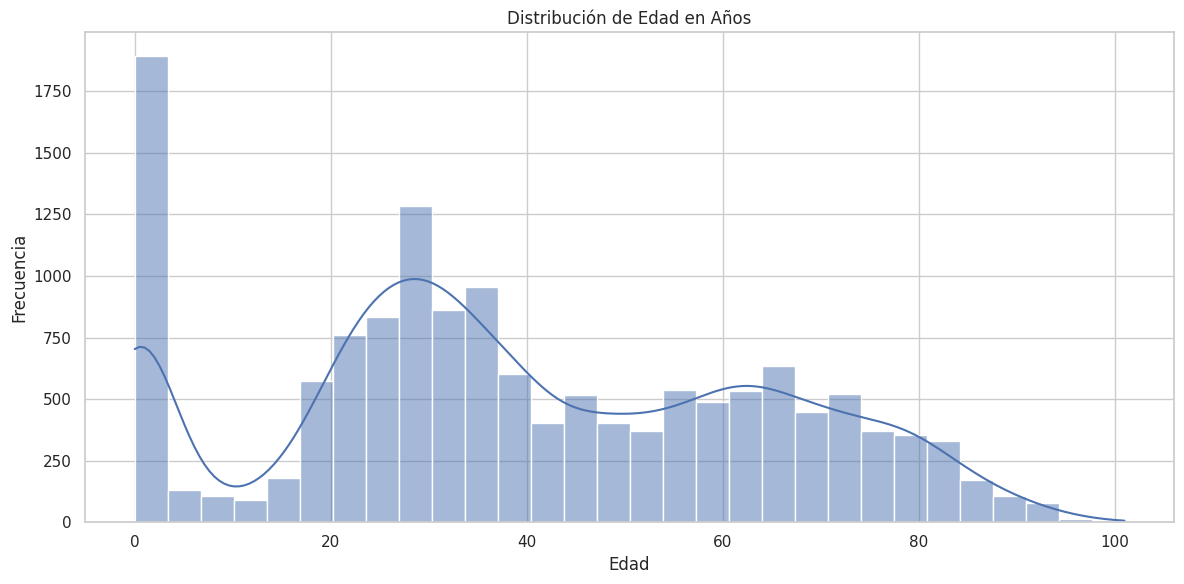

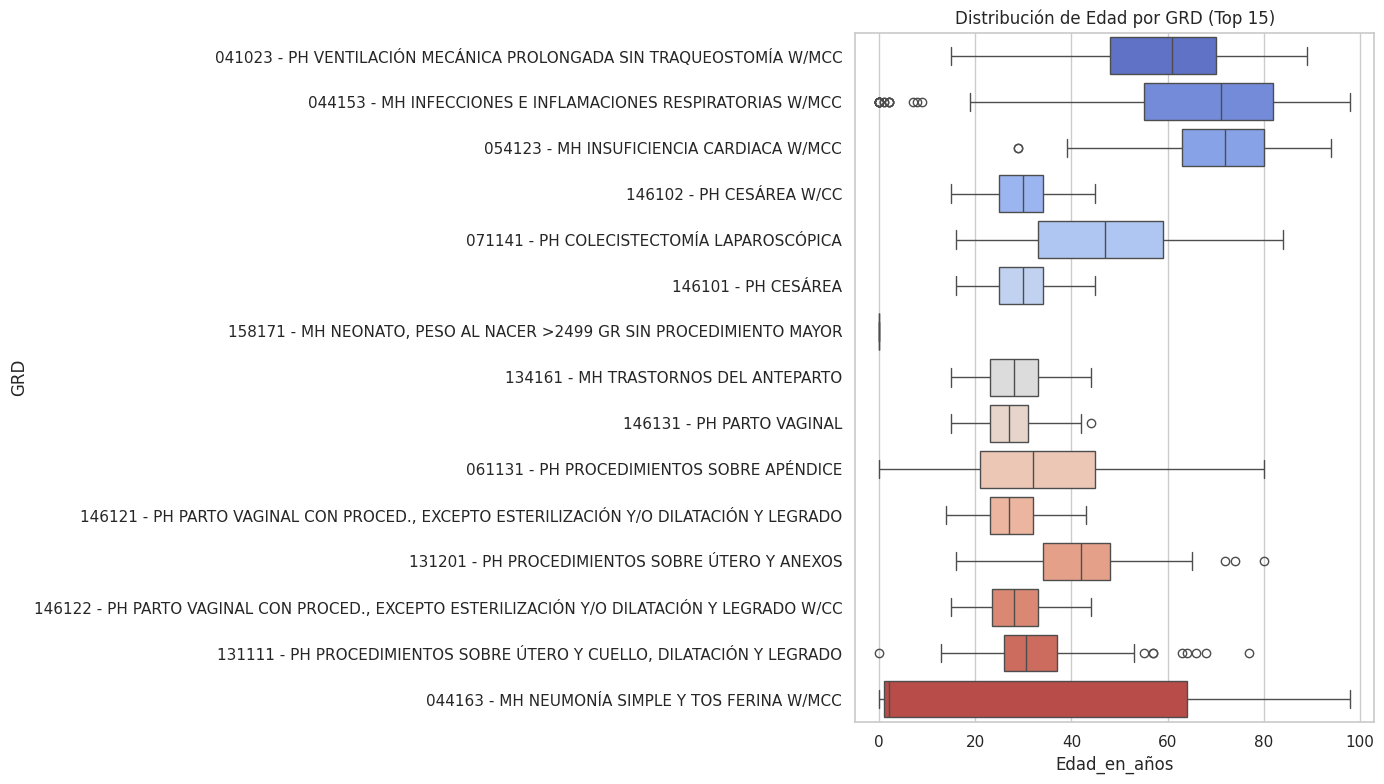




count     14560
unique        2
top       Mujer
freq       9616
Name: Sexo_Desc, dtype: object

Distribución porcentual de sexo:
Sexo_Desc
Mujer     66.043956
Hombre    33.956044
Name: proportion, dtype: float64


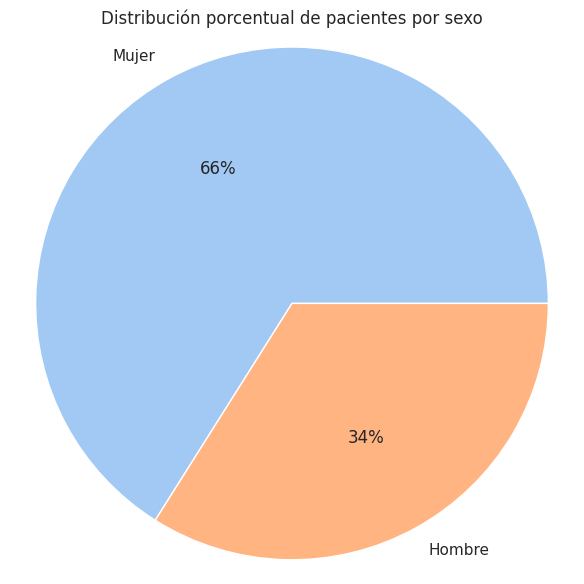

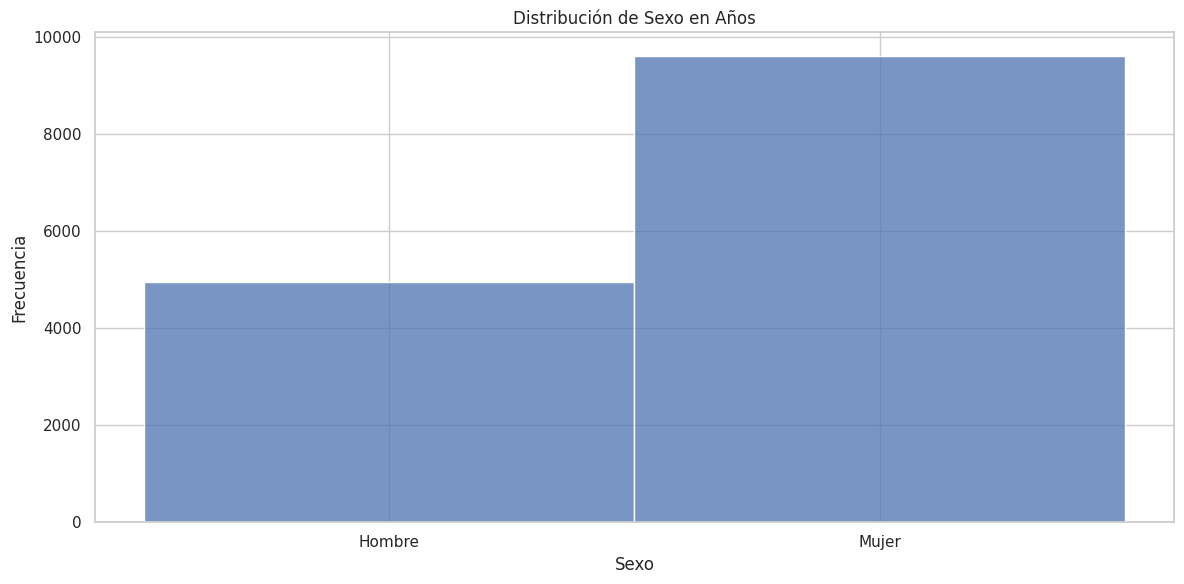

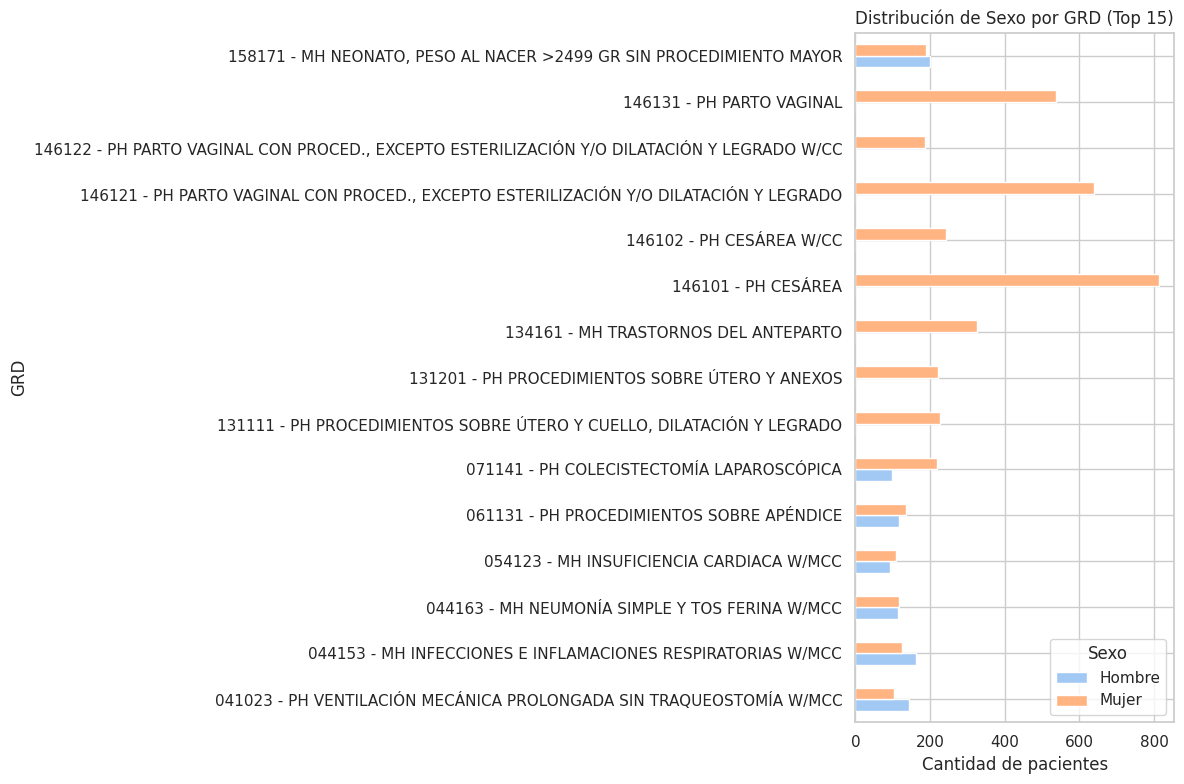

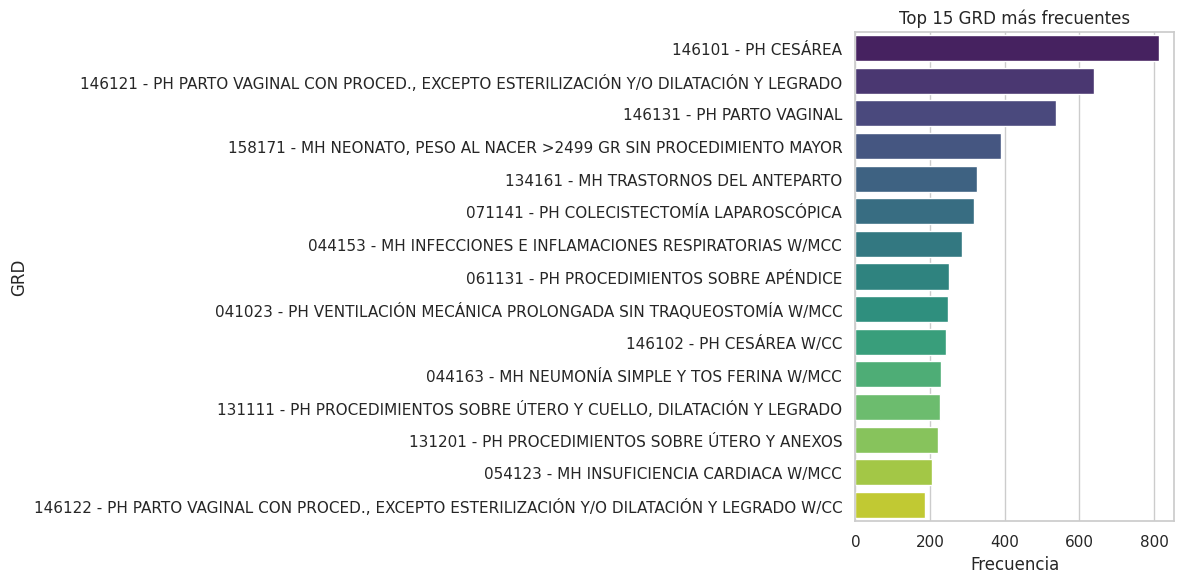

In [16]:
# ANÁLLISIS DE DATOS

# Outliers Edad
total_filas = df_pandas.shape[0]
filtro_edad_valida = (df_pandas["Edad_en_años"] >= 0) & (df_pandas["Edad_en_años"] <= 110)
filas_validas = df_pandas[filtro_edad_valida].shape[0]
outliers = total_filas - filas_validas

print(f"Filas totales: {total_filas}")
print(f"Filas válidas (edad entre 0 y 110): {filas_validas}")
print(f"Outliers a eliminar: {outliers}")

df_pandas = df_pandas[filtro_edad_valida].copy()

# Porcentaje de nulos por columna
porcentaje_nulos = df_pandas.isnull().mean().sort_values(ascending=False).to_frame(name="Porcentaje_nulos")
print(porcentaje_nulos)

sns.set(style="whitegrid")

print("\n\n")

# Top 15 GRDs más frecuentes
top_grd = df_pandas["GRD"].value_counts().nlargest(15)
grd_frecuentes = top_grd.index.tolist()
df_filtrado = df_pandas[df_pandas["GRD"].isin(grd_frecuentes)]

# DESCRIPTTIVA EDAD
# Estadísticas generales de la variable Edad
print(df_pandas["Edad_en_años"].describe())

# Histograma de edad
plt.figure(figsize=(12, 6))
sns.histplot(df_pandas["Edad_en_años"], bins=30, kde=True)
plt.title("Distribución de Edad en Años")
plt.xlabel("Edad")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()
print("\n\n")

# Boxplot Edad vs GRD

plt.figure(figsize=(14, 8))
sns.boxplot(data=df_filtrado, x="Edad_en_años", y="GRD", hue="GRD", palette="coolwarm", legend=False)
plt.title("Distribución de Edad por GRD (Top 15)")
plt.xlabel("Edad_en_años")
plt.ylabel("GRD")
plt.tight_layout()
plt.show()
print("\n\n")

# DESCRIPTIVA SEXO
# Estadísticas generales de la variable Sexo
print(df_pandas["Sexo_Desc"].describe())

# Distribución porcentual por sexo
porcentaje_sexo = df_pandas["Sexo_Desc"].value_counts(normalize=True) * 100
print("\nDistribución porcentual de sexo:")
print(porcentaje_sexo)

# Gráfico circular
plt.figure(figsize=(6, 6))
plt.pie(porcentaje_sexo, labels=porcentaje_sexo.index, autopct='%1.0f%%', colors=sns.color_palette("pastel"))
plt.title("Distribución porcentual de pacientes por sexo")
plt.axis("equal")  # Para asegurar que el círculo no esté deformado
plt.tight_layout()
plt.show()
print("\n\n")

# Histograma de Sexo
plt.figure(figsize=(12, 6))
sns.histplot(df_pandas["Sexo_Desc"], bins="auto", kde=False)
plt.title("Distribución de Sexo en Años")
plt.xlabel("Sexo")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()
print("\n\n")

# Boxplot Sexo vs GRD

# Crear tabla cruzada de conteo por GRD y Sexo
conteo_grd_sexo = df_filtrado.groupby(["GRD", "Sexo_Desc"]).size().unstack(fill_value=0)

# Gráfico de barras agrupadas
conteo_grd_sexo.plot(kind="barh", stacked=False, figsize=(12, 8), color=sns.color_palette("pastel"))
plt.title("Distribución de Sexo por GRD (Top 15)")
plt.xlabel("Cantidad de pacientes")
plt.ylabel("GRD")
plt.legend(title="Sexo")
plt.tight_layout()
plt.show()
print("\n\n")

# GRD
# Gráfico de barras Frecuencia GRD
plt.figure(figsize=(12, 6))
sns.barplot(y=top_grd.index, x=top_grd.values, orient="h", hue=top_grd.index, palette="viridis", legend=False)
plt.title("Top 15 GRD más frecuentes")
plt.xlabel("Frecuencia")
plt.ylabel("GRD")
plt.tight_layout()
plt.show()

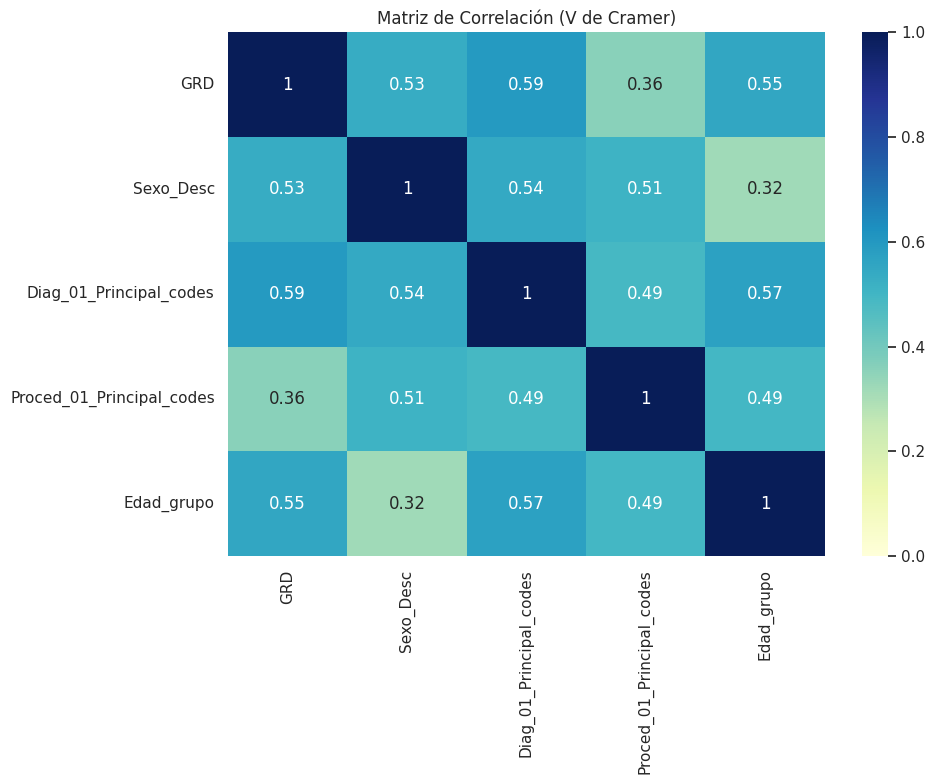

In [17]:
# Correlación de variables con V de Cramer

# Seleccionar variables categóricas para el análisis
categorial_columns = ["GRD", "Sexo_Desc", "Diag_01_Principal_codes", "Proced_01_Principal_codes", "Edad_grupo"]

# Crear matriz de V de Cramer
matriz_v = pd.DataFrame(index=categorial_columns, columns=categorial_columns)

for col1 in categorial_columns:
    for col2 in categorial_columns:
        if col1 == col2:
            matriz_v.loc[col1, col2] = 1.0
        else:
            matriz_v.loc[col1, col2] = cramers_v(df_pandas[col1], df_pandas[col2])

# Convertir a float
matriz_v = matriz_v.astype(float)

# Mostrar heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(matriz_v, annot=True, cmap="YlGnBu", vmin=0, vmax=1)
plt.title("Matriz de Correlación (V de Cramer)")
plt.tight_layout()
plt.show()


Entrenando modelo con GRU...
Epoch 1/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 24s 112ms/step - accuracy: 0.0642 - loss: 4.1146 - sparse_top_k_categorical_accuracy: 0.2389 - val_accuracy: 0.3428 - val_loss: 4.0889 - val_sparse_top_k_categorical_accuracy: 0.6820
Epoch 2/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 20s 107ms/step - accuracy: 0.3131 - loss: 4.0293 - sparse_top_k_categorical_accuracy: 0.6609 - val_accuracy: 0.4066 - val_loss: 4.0390 - val_sparse_top_k_categorical_accuracy: 0.7416
Epoch 3/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 20s 103ms/step - accuracy: 0.3917 - loss: 4.0721 - sparse_top_k_categorical_accuracy: 0.7298 - val_accuracy: 0.4241 - val_loss: 3.9632 - val_sparse_top_k_categorical_accuracy: 0.7769
Epoch 4/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 20s 102ms/step - accuracy: 0.3577 - loss: 4.0291 - sparse_top_k_categorical_accuracy: 0.7387 - val_accuracy: 0.2363 - val_loss: 3.5416 - val_sparse_top_k_categorical_accuracy: 0.6129
Epoch 5/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 22s 113ms/step - accuracy: 0.1865 - lo

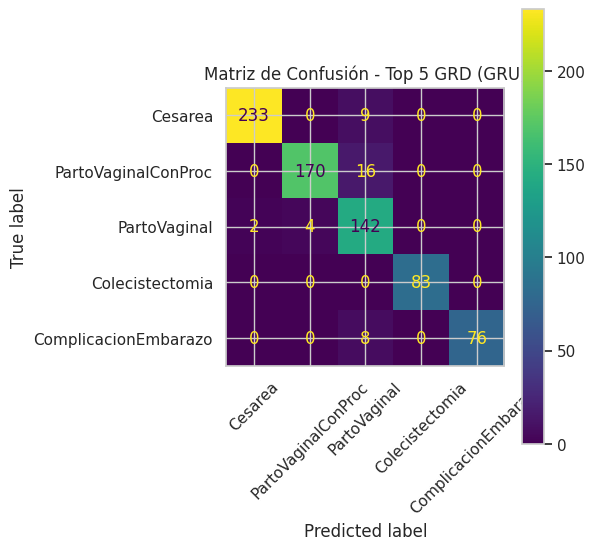


Entrenando modelo con LSTM...
Epoch 1/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 38s 228ms/step - accuracy: 0.0416 - loss: 3.9801 - sparse_top_k_categorical_accuracy: 0.1516 - val_accuracy: 0.2795 - val_loss: 3.9256 - val_sparse_top_k_categorical_accuracy: 0.4673
Epoch 2/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 40s 219ms/step - accuracy: 0.2829 - loss: 3.9328 - sparse_top_k_categorical_accuracy: 0.4894 - val_accuracy: 0.2215 - val_loss: 3.8740 - val_sparse_top_k_categorical_accuracy: 0.5638
Epoch 3/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 41s 219ms/step - accuracy: 0.1631 - loss: 3.8246 - sparse_top_k_categorical_accuracy: 0.4823 - val_accuracy: 0.1086 - val_loss: 3.2747 - val_sparse_top_k_categorical_accuracy: 0.4520
Epoch 4/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 41s 220ms/step - accuracy: 0.1322 - loss: 3.6451 - sparse_top_k_categorical_accuracy: 0.4482 - val_accuracy: 0.1635 - val_loss: 3.0924 - val_sparse_top_k_categorical_accuracy: 0.4325
Epoch 5/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 26s 222ms/step - accuracy: 0.1637 - l

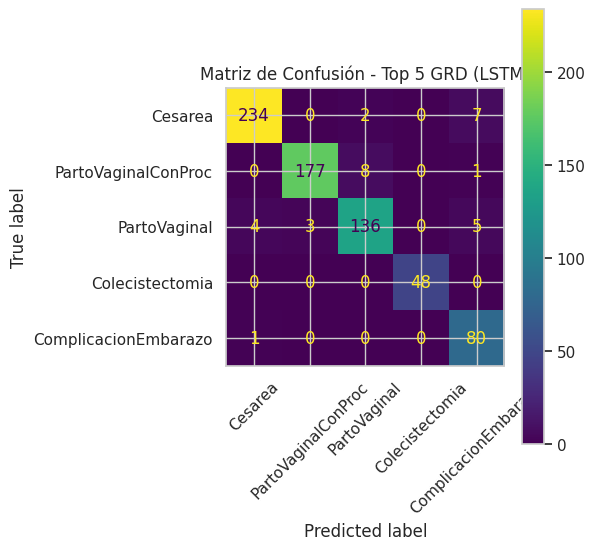


Entrenando modelo con RNN...
Epoch 1/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 15s 52ms/step - accuracy: 0.0209 - loss: 3.9580 - sparse_top_k_categorical_accuracy: 0.0995 - val_accuracy: 0.0200 - val_loss: 3.9240 - val_sparse_top_k_categorical_accuracy: 0.1129
Epoch 2/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.0242 - loss: 4.0077 - sparse_top_k_categorical_accuracy: 0.1142 - val_accuracy: 0.0517 - val_loss: 3.9091 - val_sparse_top_k_categorical_accuracy: 0.2700
Epoch 3/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.0271 - loss: 3.9545 - sparse_top_k_categorical_accuracy: 0.1269 - val_accuracy: 0.1308 - val_loss: 3.9024 - val_sparse_top_k_categorical_accuracy: 0.3486
Epoch 4/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.0288 - loss: 3.9351 - sparse_top_k_categorical_accuracy: 0.1413 - val_accuracy: 0.1793 - val_loss: 3.8893 - val_sparse_top_k_categorical_accuracy: 0.4483
Epoch 5/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.0387 - loss: 3.942

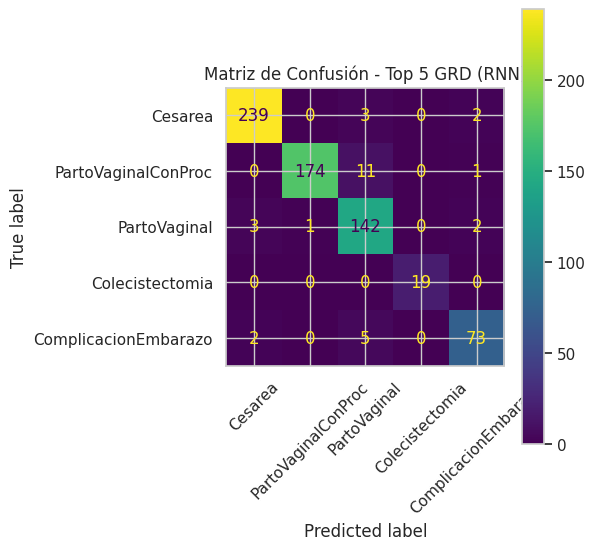

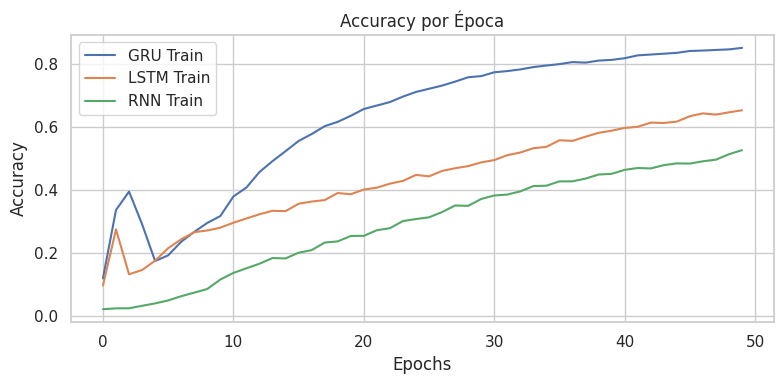

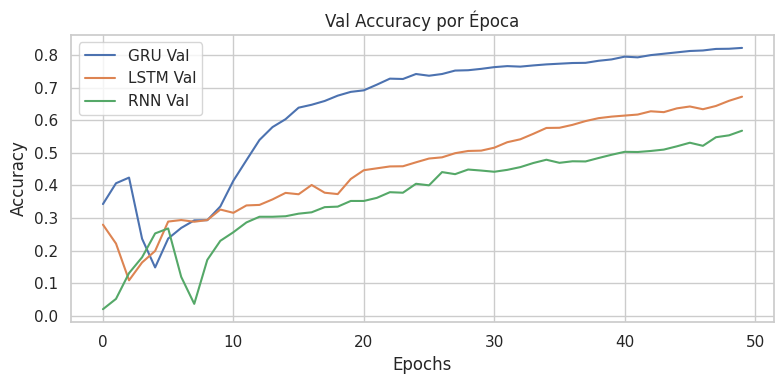

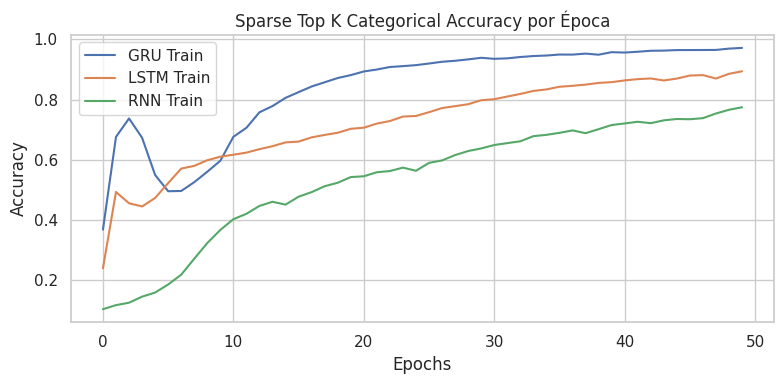

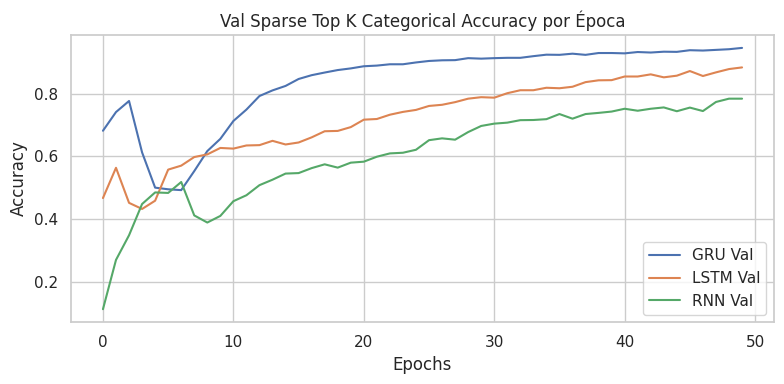

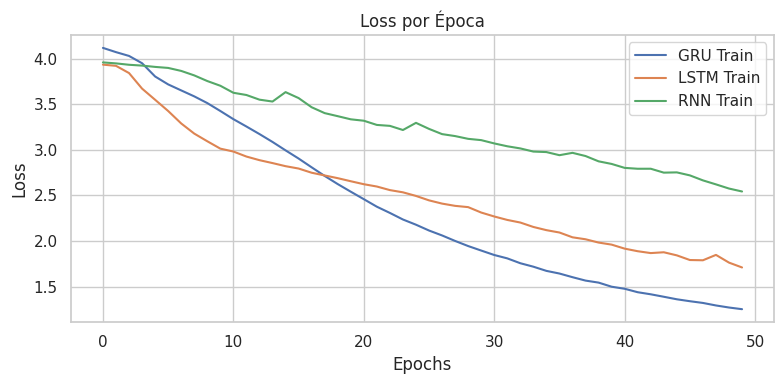

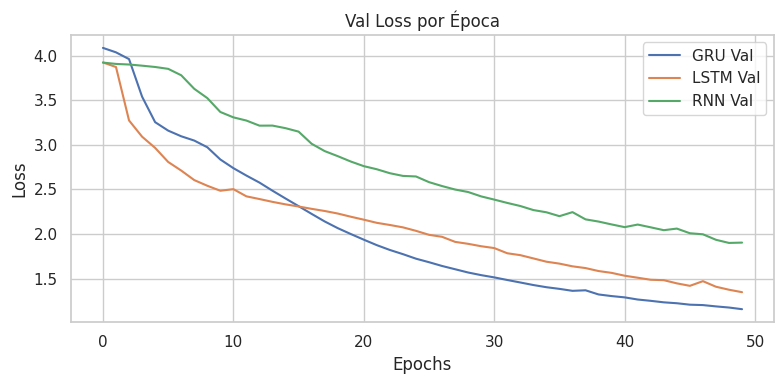

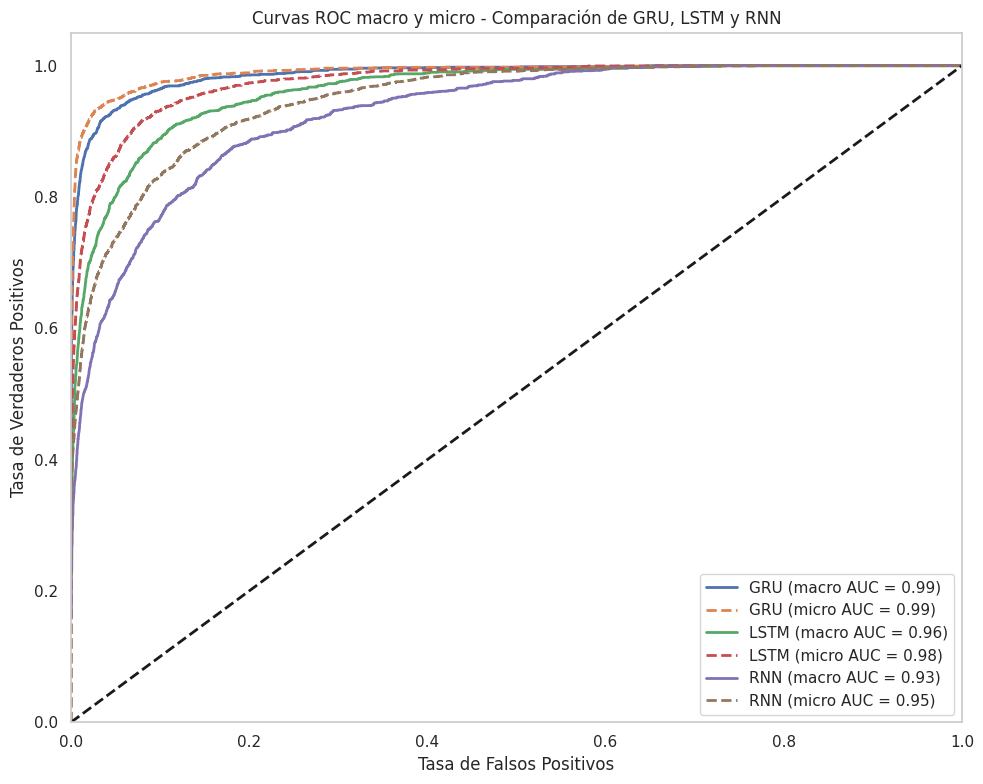

In [18]:
# === Agrupación automática por GRD base (sin severidad final) ===
df_pandas['GRD'] = df_pandas['GRD'].astype(str)
df_pandas['GRD_agrupado'] = df_pandas['GRD'].str.extract(r'(\d{5})')

# Mapeo clínico opcional para legibilidad
grd_agrupado_nombre = {
    '14610': 'Cesarea',
    '14612': 'PartoVaginalConProc',
    '14613': 'PartoVaginal',
    '07114': 'Colecistectomia',
    '13416': 'ComplicacionEmbarazo',
    '15817': 'NeonatoSinProc',
    '11412': 'InfUrinaria',
    '05412': 'InsufCardiaca',
    '04415': 'InfeccionRespiratoria',
    '04416': 'Neumonia',
    '04418': 'AsmaBronquitis',
    '06120': 'ProcDigestivoComplejo',
    '04101': 'VentilacionProlongada',
    '04102': 'VentilacionProlongada',
    '05410': 'InfartoAgudo',
    '21412': 'PartoInstrumental',
    '06418': 'GastritisUlceras',
    '13111': 'NeumoniaLeve',
    '09413': 'RNComplicacionesLeves',
    '13130': 'NeumoniaGrave',
    '13120': 'NeumoniaModerada',
    '06113': 'CirugiaDigestivaMayor',
    '06417': 'Pancreatitis',
    '11413': 'ITUComplicada',
    '10410': 'TractoUrinarioLeve',
    '22412': 'ComplicacionObstetricaAguda',
    '01414': 'PartoVaginalSinComplicaciones',
    '09412': 'ReciénNacidoSano',
    '07410': 'ColelitiasisSinCx',
    '08130': 'ApendicitisComplicada',
    '07412': 'ColecistitisSinCirugia',
    '05415': 'InsufCardiacaComplicada',
    '07414': 'ColecistectomiaAbierta',
    '07413': 'ColecistectomiaLaparoscopica',
    '09140': 'CesareaComplicadaLeve',
    '04411': 'InfeccionRespiratoriaAlta',
    '01424': 'ComplicacionesMenoresEmbarazo',
    '01422': 'EmbarazoConHTA',
    '11120': 'ITUNoComplicada',
    '06112': 'CirugiaDigestivaMenor',
    '11410': 'ITUComplicacionMedia',
    '04412': 'AsmaLeve',
    '13110': 'NeumoniaNoEspecificada',
    '04120': 'VentilacionProlongadaMCC',
    '12120': 'InfeccionAbdominal',
    '05419': 'TrastornosCirculatorios',
    '16413': 'ProblemasPerinatalesVarios',
    '13113': 'NeumoniaConComplicacion',
    '15813': 'NeonatoPrematuroLeve'
}
df_pandas['GRD_agrupado_nombre'] = df_pandas['GRD_agrupado'].map(grd_agrupado_nombre).fillna(df_pandas['GRD_agrupado'])

# === Preparación de secuencias ===
# Seleccionar solo los primeros 5 diagnósticos/procedimientos
code_cols = [col for col in df_pandas.columns if 'Diag' in col][:5]

# Limpiar los códigos
for col in code_cols:
    df_pandas[col] = df_pandas[col].astype(str).apply(lambda x: re.sub(r'\.', '', x.strip()))

# Asegurar que Sexo_Desc y Edad_grupo no tengan nulos
df_pandas['Sexo_Desc'] = df_pandas['Sexo_Desc'].fillna('UNKNOWN')
df_pandas['Edad_grupo'] = df_pandas['Edad_grupo'].fillna('UNKNOWN')

# Crear tokens personalizados para sexo y edad
df_pandas['sexo_token'] = 'SEXO_' + df_pandas['Sexo_Desc'].astype(str).str.upper().str.replace(' ', '_')
df_pandas['edad_token'] = 'EDAD_' + df_pandas['Edad_grupo'].astype(str).str.upper().str.replace(' ', '_')

# Crear secuencias combinando códigos + sexo + edad
all_seq_cols = code_cols + ['sexo_token', 'edad_token']
secuencias = df_pandas[all_seq_cols].agg(' '.join, axis=1).str.replace(r'\bnan\b', '', regex=True).str.strip().str.split()

# === Entrenar Word2Vec ===
embedding_dim = 50
modelo_w2v = Word2Vec(sentences=secuencias, vector_size=embedding_dim, window=5, min_count=2, workers=4, sg=1)

# === Tokenización y Padding ===
tokenizer = Tokenizer()
tokenizer.fit_on_texts([' '.join(seq) for seq in secuencias])
sequences = tokenizer.texts_to_sequences([' '.join(seq) for seq in secuencias])

X_seq_filtered = pad_sequences(sequences, maxlen=30, padding='post')
y_seq_filtered = df_pandas['GRD_agrupado_nombre'].values

# === Crear embedding_matrix ===
vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if word in modelo_w2v.wv:
        embedding_matrix[i] = modelo_w2v.wv[word]
    else:
        embedding_matrix[i] = np.random.normal(scale=0.01, size=embedding_dim)

# === Filtrar top 50 GRDs ===
top_50_grds = [grd for grd, _ in Counter(y_seq_filtered).most_common(50)]
mask = np.isin(y_seq_filtered, top_50_grds)
X_top50 = X_seq_filtered[mask]
y_top50 = y_seq_filtered[mask]

# === Codificar etiquetas ===
le = LabelEncoder()
y_top50_encoded = le.fit_transform(y_top50)
num_classes = len(le.classes_)

# === Separar datos ===
X_train, X_test, y_train, y_test = train_test_split(
    X_top50, y_top50_encoded, test_size=0.2, stratify=y_top50_encoded, random_state=42
)

# === Oversampling ===
y_train_series = pd.Series(y_train)
class_counts = y_train_series.value_counts()
desired_minimum = 100
sampling_strategy = {
    cls: desired_minimum for cls, count in class_counts.items() if count < desired_minimum
}
ros = RandomOverSampler(sampling_strategy=sampling_strategy, random_state=42)
X_train_bal, y_train_bal = ros.fit_resample(X_train, y_train)

# === Calcular class weights ===
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

# === Definir build_model ===
def build_model(
        rnn_type='GRU',
        units=128,
        dropout_rate=0.5,
        recurrent_dropout_rate=0.3,
        embedding_matrix=None,
        num_classes=None,
        l2_reg=1e-4,
        learning_rate=1e-4
):
    vocab_size, embedding_dim = embedding_matrix.shape
    model = Sequential()
    model.add(Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        trainable=True
    ))

    if rnn_type == 'GRU':
        model.add(Bidirectional(GRU(units, return_sequences=False, dropout=dropout_rate,
                                    recurrent_dropout=recurrent_dropout_rate,
                                    kernel_regularizer=l2(l2_reg))))
    elif rnn_type == 'LSTM':
        model.add(Bidirectional(LSTM(units, return_sequences=False, dropout=dropout_rate,
                                     recurrent_dropout=recurrent_dropout_rate,
                                     kernel_regularizer=l2(l2_reg))))
    elif rnn_type == 'RNN':
        model.add(Bidirectional(SimpleRNN(units, return_sequences=False, dropout=dropout_rate,
                                          recurrent_dropout=recurrent_dropout_rate,
                                          kernel_regularizer=l2(l2_reg))))
    else:
        raise ValueError("Tipo de RNN no válido. Usa 'GRU', 'LSTM' o 'RNN'.")

    model.add(Dense(num_classes, activation='softmax', kernel_regularizer=l2(l2_reg)))
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy', SparseTopKCategoricalAccuracy(k=5)])
    return model

# === Entrenamiento y evaluación ===
models = {}
histories = {}
prob_dict = {}
for rnn in ['GRU', 'LSTM', 'RNN']:
    print(f"\nEntrenando modelo con {rnn}...")
    # Parámetros recomendados para cada tipo de RNN
    if rnn == 'GRU':
        units = 64
        dropout = 0.3
        rec_dropout = 0.3
        l2_regularization = 1e-3
    elif rnn == 'LSTM':
        units = 128
        dropout = 0.4
        rec_dropout = 0.3
        l2_regularization = 1e-4
    else:  # SimpleRNN
        units = 64
        dropout = 0.3
        rec_dropout = 0.2
        l2_regularization = 1e-4

    # Construcción del modelo
    model = build_model(
        rnn_type=rnn,
        units=units,
        dropout_rate=dropout,
        recurrent_dropout_rate=rec_dropout,
        embedding_matrix=embedding_matrix,
        num_classes=num_classes,
        l2_reg=l2_regularization
    )

    early_stop = EarlyStopping(patience=5, restore_best_weights=True)
    history = model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=64,
        validation_split=0.2,
        class_weight=class_weights,
        callbacks=[early_stop],
        verbose=1
    )
    models[rnn] = model
    histories[rnn] = history

    # Evaluación
    loss, acc, top5_acc = model.evaluate(X_test, y_test)
    print(f"\n{rnn} - Test Accuracy: {acc:.4f} | Top-5 Accuracy: {top5_acc:.4f}")

    y_pred = model.predict(X_test)
    prob_dict[rnn] = y_pred
    y_pred_classes = y_pred.argmax(axis=1)
    print(f"\nClassification Report ({rnn}):")
    print(classification_report(y_test, y_pred_classes, target_names=[str(c) for c in le.classes_], zero_division=0))

    # Matriz de confusión Top 5
    top5_ids, top5_counts = np.unique(y_test, return_counts=True)
    top5_sorted = sorted(zip(top5_ids, top5_counts), key=lambda x: -x[1])[:5]
    top5_grd_ids = [x[0] for x in top5_sorted]
    mask_top5 = np.isin(y_test, top5_grd_ids)
    y_test_top5 = y_test[mask_top5]
    y_pred_top5 = y_pred_classes[mask_top5]
    top5_labels = [le.classes_[i] for i in top5_grd_ids]
    cm_top5 = confusion_matrix(y_test_top5, y_pred_top5, labels=top5_grd_ids)
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_top5, display_labels=top5_labels)
    disp.plot(ax=ax, cmap='viridis', xticks_rotation=45)
    plt.title(f"Matriz de Confusión - Top 5 GRD ({rnn})")
    plt.tight_layout()
    plt.show()

# === Gráficas de entrenamiento ===
for metric in ['accuracy', 'val_accuracy', 'sparse_top_k_categorical_accuracy', 'val_sparse_top_k_categorical_accuracy',
               'loss', 'val_loss']:
    plt.figure(figsize=(8, 4))
    for rnn in ['GRU', 'LSTM', 'RNN']:
        label = f"{rnn} {'Val' if 'val' in metric else 'Train'}"
        plt.plot(histories[rnn].history[metric], label=label)
    plt.title(f"{metric.replace('_', ' ').title()} por Época")
    plt.xlabel('Epochs')
    plt.ylabel(metric.split('_')[-1].title())
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    print()
    plt.show()

# === Comparación ROC ===
print()
plot_models_macro_micro_roc(y_test, prob_dict, num_classes)